## 1. Configuración e Importación

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Carga de Datos Procesados

In [10]:
X_train = pd.read_csv('../data_processed/X_train.csv')
X_test = pd.read_csv('../data_processed/X_test.csv')
y_train = pd.read_csv('../data_processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data_processed/y_test.csv').values.ravel()

y_train = (y_train == 'Yes').astype(int)
y_test = (y_test == 'Yes').astype(int)

print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)
print("\nDistribución de y_train:", np.bincount(y_train))
print("Distribución de y_test:", np.bincount(y_test))

Shape de X_train: (5634, 19)
Shape de X_test: (1409, 19)
Shape de y_train: (5634,)
Shape de y_test: (1409,)

Distribución de y_train: [4139 1495]
Distribución de y_test: [1035  374]


**Resultados de Carga de Datos:**

- El conjunto de entrenamiento contiene 5,634 observaciones con 19 variables predictoras.
- El conjunto de prueba contiene 1,409 observaciones, representando el 20% del dataset total.
- La distribución de clases en entrenamiento es de 4,139 clientes sin churn (73.5%) y 1,495 con churn (26.5%).
- La distribución de clases en prueba es de 1,035 clientes sin churn (73.5%) y 374 con churn (26.5%).
- La estratificación mantuvo proporcionalmente la misma distribución de churn en ambos conjuntos.

## 3. Definición de Pipelines

In [11]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X_train.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocesador creado exitosamente")

Preprocesador creado exitosamente


In [12]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

pipeline_catboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=42, verbose=0))
])

pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

print("Pipelines creados exitosamente")

Pipelines creados exitosamente


## 4. Definición de Grids de Hiperparámetros

In [13]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

param_grid_catboost = {
    'classifier__iterations': [100, 200, 300],
    'classifier__depth': [4, 6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__l2_leaf_reg': [1, 3, 5, 7]
}

param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__num_leaves': [31, 50, 70],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

print("Grids de hiperparámetros definidos")

Grids de hiperparámetros definidos


## 5. Configuración de GridSearchCV

In [14]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_catboost = GridSearchCV(
    estimator=pipeline_catboost,
    param_grid=param_grid_catboost,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid_lgbm = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm,
    cv=cv_strategy,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

print("GridSearchCV configurados exitosamente")

GridSearchCV configurados exitosamente


## 6. Entrenamiento de Modelos con GridSearchCV

In [15]:
print("Entrenando Random Forest...")
grid_rf.fit(X_train, y_train)
print("Random Forest - Mejores parámetros:", grid_rf.best_params_)
print("Random Forest - Mejor score (ROC-AUC):", grid_rf.best_score_)

Entrenando Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


Random Forest - Mejores parámetros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Random Forest - Mejor score (ROC-AUC): 0.8456278511120072


**Resultados de Random Forest:**

- El modelo evaluó 108 combinaciones de hiperparámetros en 5 folds, totalizando 540 ajustes.
- Los mejores hiperparámetros son: 200 estimadores, profundidad máxima de 10, mínimo 2 muestras para dividir y mínimo 4 muestras en hojas.
- El mejor score de validación cruzada alcanzó un ROC-AUC de 0.8456.

In [16]:
print("Entrenando XGBoost...")
grid_xgb.fit(X_train, y_train)
print("XGBoost - Mejores parámetros:", grid_xgb.best_params_)
print("XGBoost - Mejor score (ROC-AUC):", grid_xgb.best_score_)

Entrenando XGBoost...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
XGBoost - Mejores parámetros: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}
XGBoost - Mejor score (ROC-AUC): 0.8494205664958585
XGBoost - Mejores parámetros: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}
XGBoost - Mejor score (ROC-AUC): 0.8494205664958585


**Resultados de XGBoost:**

- El modelo evaluó 324 combinaciones de hiperparámetros en 5 folds, totalizando 1,620 ajustes.
- Los mejores hiperparámetros son: 300 estimadores, profundidad máxima de 5, tasa de aprendizaje de 0.01, subsample de 0.9 y colsample_bytree de 0.8.
- El mejor score de validación cruzada alcanzó un ROC-AUC de 0.8494, el más alto de los cuatro modelos evaluados.

In [17]:
print("Entrenando CatBoost...")
grid_catboost.fit(X_train, y_train)
print("CatBoost - Mejores parámetros:", grid_catboost.best_params_)
print("CatBoost - Mejor score (ROC-AUC):", grid_catboost.best_score_)

Entrenando CatBoost...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
CatBoost - Mejores parámetros: {'classifier__depth': 4, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.1}
CatBoost - Mejor score (ROC-AUC): 0.8489958388810459
CatBoost - Mejores parámetros: {'classifier__depth': 4, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.1}
CatBoost - Mejor score (ROC-AUC): 0.8489958388810459


**Resultados de CatBoost:**

- El modelo evaluó 144 combinaciones de hiperparámetros en 5 folds, totalizando 720 ajustes.
- Los mejores hiperparámetros son: 100 iteraciones, profundidad de 4, regularización L2 de 5 y tasa de aprendizaje de 0.1.
- El mejor score de validación cruzada alcanzó un ROC-AUC de 0.8490, muy cercano al resultado de XGBoost.

In [18]:
print("Entrenando LightGBM...")
grid_lgbm.fit(X_train, y_train)
print("LightGBM - Mejores parámetros:", grid_lgbm.best_params_)
print("LightGBM - Mejor score (ROC-AUC):", grid_lgbm.best_score_)

Entrenando LightGBM...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
LightGBM - Mejores parámetros: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__num_leaves': 50, 'classifier__subsample': 0.8}
LightGBM - Mejor score (ROC-AUC): 0.8477145632091082
LightGBM - Mejores parámetros: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 300, 'classifier__num_leaves': 50, 'classifier__subsample': 0.8}
LightGBM - Mejor score (ROC-AUC): 0.8477145632091082


**Resultados de LightGBM:**

- El modelo evaluó 324 combinaciones de hiperparámetros en 5 folds, totalizando 1,620 ajustes.
- Los mejores hiperparámetros son: 300 estimadores, profundidad máxima de 5, tasa de aprendizaje de 0.01, 50 hojas y subsample de 0.8.
- El mejor score de validación cruzada alcanzó un ROC-AUC de 0.8477, posicionándose en tercer lugar.

## 7. Evaluación de Modelos en Conjunto de Prueba

### 7.1 Random Forest

RANDOM FOREST - Resultados en Conjunto de Prueba

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


ROC-AUC Score: 0.8428


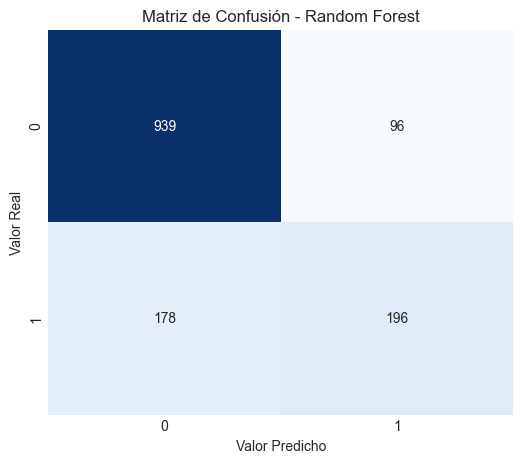

In [19]:
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("=" * 50)
print("RANDOM FOREST - Resultados en Conjunto de Prueba")
print("=" * 50)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

**Evaluación de Random Forest en Conjunto de Prueba:**

- El modelo alcanzó un ROC-AUC de 0.8428 en el conjunto de prueba.
- La precisión para clientes sin churn (clase 0) es de 0.84, con un recall de 0.91.
- La precisión para clientes con churn (clase 1) es de 0.67, con un recall de 0.52.
- La accuracy general es de 0.81 (1,140 predicciones correctas de 1,409 casos).
- La matriz de confusión muestra 939 verdaderos negativos, 196 verdaderos positivos, 96 falsos positivos y 178 falsos negativos.
- El modelo identifica correctamente el 91% de los clientes que no abandonarán, pero solo detecta el 52% de los clientes que sí harán churn.

### 7.2 XGBoost

XGBOOST - Resultados en Conjunto de Prueba

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


ROC-AUC Score: 0.8476


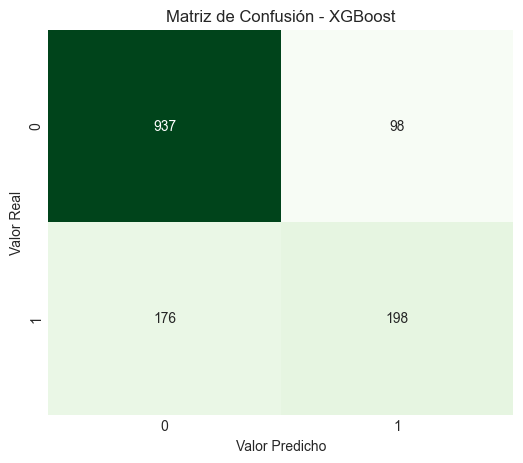

In [20]:
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("=" * 50)
print("XGBOOST - Resultados en Conjunto de Prueba")
print("=" * 50)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_xgb))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

**Evaluación de XGBoost en Conjunto de Prueba:**

- El modelo alcanzó un ROC-AUC de 0.8476 en el conjunto de prueba, el más alto de los cuatro modelos.
- La precisión para clientes sin churn (clase 0) es de 0.84, con un recall de 0.91.
- La precisión para clientes con churn (clase 1) es de 0.67, con un recall de 0.53.
- La accuracy general es de 0.81 (1,135 predicciones correctas de 1,409 casos).
- La matriz de confusión muestra 937 verdaderos negativos, 198 verdaderos positivos, 98 falsos positivos y 176 falsos negativos.
- El modelo mejora ligeramente el recall para la clase minoritaria (53% vs 52% de Random Forest), detectando 2 casos adicionales de churn.

### 7.3 CatBoost

CATBOOST - Resultados en Conjunto de Prueba

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409


ROC-AUC Score: 0.8474


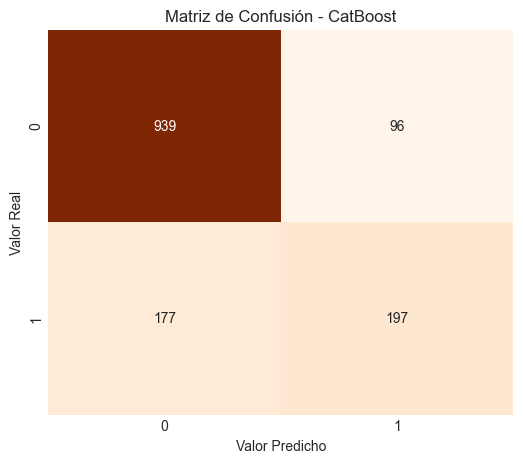

In [21]:
best_catboost = grid_catboost.best_estimator_
y_pred_catboost = best_catboost.predict(X_test)
y_proba_catboost = best_catboost.predict_proba(X_test)[:, 1]

print("=" * 50)
print("CATBOOST - Resultados en Conjunto de Prueba")
print("=" * 50)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_catboost))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_catboost):.4f}")

cm_catboost = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_catboost, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title('Matriz de Confusión - CatBoost')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

**Evaluación de CatBoost en Conjunto de Prueba:**

- El modelo alcanzó un ROC-AUC de 0.8474 en el conjunto de prueba, muy cercano al desempeño de XGBoost.
- La precisión para clientes sin churn (clase 0) es de 0.84, con un recall de 0.91.
- La precisión para clientes con churn (clase 1) es de 0.67, con un recall de 0.53.
- La accuracy general es de 0.81 (1,136 predicciones correctas de 1,409 casos).
- La matriz de confusión muestra 939 verdaderos negativos, 197 verdaderos positivos, 96 falsos positivos y 177 falsos negativos.
- El desempeño es prácticamente idéntico a XGBoost, con apenas una diferencia de 0.0002 en ROC-AUC.

### 7.4 LightGBM

LIGHTGBM - Resultados en Conjunto de Prueba

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409


ROC-AUC Score: 0.8435


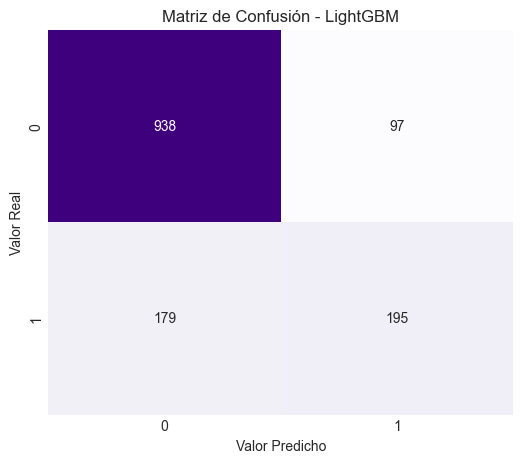

In [22]:
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

print("=" * 50)
print("LIGHTGBM - Resultados en Conjunto de Prueba")
print("=" * 50)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_lgbm))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba_lgbm):.4f}")

cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('Matriz de Confusión - LightGBM')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

**Evaluación de LightGBM en Conjunto de Prueba:**

- El modelo alcanzó un ROC-AUC de 0.8435 en el conjunto de prueba.
- La precisión para clientes sin churn (clase 0) es de 0.84, con un recall de 0.91.
- La precisión para clientes con churn (clase 1) es de 0.67, con un recall de 0.52.
- La accuracy general es de 0.80 (1,133 predicciones correctas de 1,409 casos).
- La matriz de confusión muestra 938 verdaderos negativos, 195 verdaderos positivos, 97 falsos positivos y 179 falsos negativos.
- El desempeño es ligeramente inferior a XGBoost y CatBoost, con el recall más bajo para la clase minoritaria (52%).

## 8. Comparación de Curvas ROC

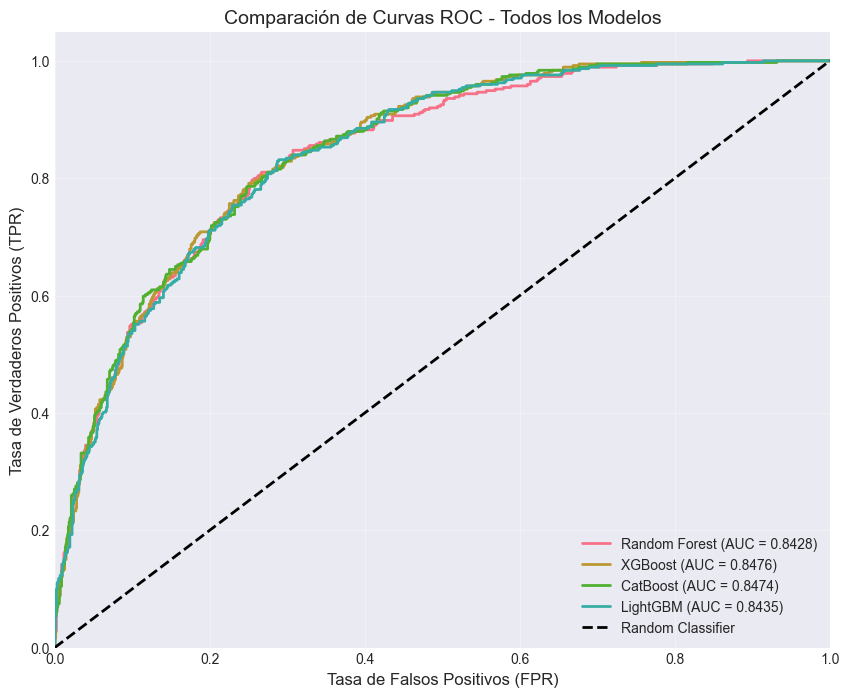

In [23]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_proba_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_proba_lgbm)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', linewidth=2)
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {roc_auc_catboost:.4f})', linewidth=2)
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {roc_auc_lgbm:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Comparación de Curvas ROC - Todos los Modelos', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

**Comparación de Curvas ROC:**

- XGBoost obtuvo el AUC más alto con 0.8476, seguido muy de cerca por CatBoost con 0.8474.
- LightGBM alcanzó un AUC de 0.8435, mientras que Random Forest obtuvo 0.8428.
- La diferencia entre el mejor (XGBoost) y el peor modelo (Random Forest) es de apenas 0.0048 puntos.
- Todos los modelos superan significativamente al clasificador aleatorio (línea diagonal), demostrando capacidad predictiva.
- Las curvas ROC están muy próximas entre sí, indicando desempeños comparables en términos de balance entre sensibilidad y especificidad.
- XGBoost y CatBoost muestran curvas prácticamente superpuestas, confirmando su desempeño similar.

## 9. Guardado de Mejores Modelos

In [25]:
import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../app', exist_ok=True)

joblib.dump(best_rf, '../models/best_rf.pkl')
joblib.dump(best_xgb, '../models/best_xgb.pkl')
joblib.dump(best_catboost, '../models/best_catboost.pkl')
joblib.dump(best_lgbm, '../models/best_lgbm.pkl')

print("Mejores modelos guardados exitosamente en ../models/")

best_model_scores = {
    'Random Forest': roc_auc_rf,
    'XGBoost': roc_auc_xgb,
    'CatBoost': roc_auc_catboost,
    'LightGBM': roc_auc_lgbm
}

best_model_name = max(best_model_scores, key=best_model_scores.get)
best_model_score = best_model_scores[best_model_name]

print(f"\nMejor modelo: {best_model_name} (ROC-AUC: {best_model_score:.4f})")

if best_model_name == 'Random Forest':
    best_model = best_rf
elif best_model_name == 'XGBoost':
    best_model = best_xgb
elif best_model_name == 'CatBoost':
    best_model = best_catboost
else:
    best_model = best_lgbm

joblib.dump(best_model, '../app/model.joblib')
print(f"Mejor modelo guardado en ../app/model.joblib para la API")

Mejores modelos guardados exitosamente en ../models/

Mejor modelo: XGBoost (ROC-AUC: 0.8476)
Mejor modelo guardado en ../app/model.joblib para la API


**Guardado de Modelos y Selección del Mejor:**

- Los cuatro modelos optimizados se guardaron exitosamente en el directorio `../models/`.
- XGBoost fue seleccionado como el mejor modelo con un ROC-AUC de 0.8476 en el conjunto de prueba.
- El modelo XGBoost se guardó adicionalmente en `../app/model.joblib` para su uso en la API de producción.
- La diferencia de desempeño entre los modelos es mínima (máximo 0.48 puntos porcentuales), lo que valida la robustez del preprocesamiento y la estrategia de validación cruzada.